In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
from tqdm import tqdm
tqdm.pandas()

/home/ivan/anaconda3/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
RS = 7345

# Загрузка данных

In [5]:
DATA_DIR = pathlib.Path("./")

In [6]:
train = pd.read_csv(DATA_DIR.joinpath("train.csv"), index_col="pair_id")
test = pd.read_csv(DATA_DIR.joinpath("test.csv"), index_col="pair_id")

In [7]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [8]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Статистика таргета

In [11]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [12]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
482717,Bridgestone Do Brasil Industria E Comercio Ltda,Bridgestone Canada Inc.,1
317233,Wright Asphalt Products Company LLC,Wright Asphalt Products Co.,1
364455,JSR Corporation,Jsr Bst Elastomer,1
353108,"JOWAT SE""/ЧЕРЕЗ ТЕРМИНАЛ В ПОЛЬШЕ","ООО""ЙОВАТ""",1
244076,GYMAP GROUP,STE GYMAP,1
286273,Bridgestone Do Brasil Industria E Comercio Ltda,Bridgestone Tire,1
222109,SOPREMA BLONIE,SOPREMA Polska Sp. z o.o.,1
303154,Total Bitumen Deutschland GmbH,Total Petrochemicals France SA,1
62325,SOPREMA GmbH,soprema Soprema sas,1


In [13]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
490544,"Eia Co., Ltd.",Zhejiang Mingri Holdings,0
162604,Importadora Gonzalez Supplies S A,Imperial Supplies Llc,0
189180,Ses International Express,Importaciones Y Representaciones Medico,0
55867,"Gti International Pvt., Ltd.",And Pantai,0
353843,La Halle,Gps Global Pallets Services Llc,0
47075,Nelson Schoenen B.V.,Rene,0
479711,Sasol Chemicals (Usa) Llc,"Shanghai Prevision Chemicals Co., Ltd.",0
133512,Ddp Specialty Electronic Materials,Metro International L.L.C.,0
207071,Oriental Trading Co. Faruqi Trading House,Kenza Trading,0


# Очистка данных

In [15]:
import pycountry
import re

In [16]:
countries = [country.name.lower() for country in pycountry.countries]

In [17]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [18]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [19]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:26<00:00,  3.76s/it]


In [20]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [21]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [22]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [23]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [11:28<00:00,  2.76s/it]


In [24]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [25]:
train.sample(25)

,name_1,name_2,is_duplicate
pair_id,,,
362115,sonica international,m v asociados s a s,0
384585,ace trading services,central trading,0
6849,megafreight srl jointly and,gap2,0
440354,the shanghaimercial,gulfmercial group,0
448936,etam pret a porter sas,prtinc,0
350565,sistemas de fletes internacionales,eia,0
192812,celanese materials,materiales de fundicion sa,0
402839,generaloa,globe tech general trading llc,0
127052,smbmercia e industria textile,colorchem international industrial,0


In [26]:
test.sample(25)

,name_1,name_2
pair_id,,
130689,polaris industries,chowdhry industries
166515,cosmos trading,wahat al falah trading
170750,hexion,zhejiang zhanghai imp exp
109596,shahbaz chemical industries,jenessco industries
5807,d s international,rachid omar hersi
158846,starkist,industrias tenazit sa de cv
50000,south asia textile industries lanka,sho international
180739,kemet de sa de cv,ch robinson de sa de cv
128742,bc,a bu weber sarl


# Простые метрики сходства строк

In [28]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [29]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 213249/213249 [00:56<00:00, 3767.67it/s]


In [30]:
train.head()

,name_1,name_2,is_duplicate,levenstein
pair_id,,,,
1,iko industries,enormous industrial trade,0,15.0
2,apcotex industries,technocraft industries,0,9.0
3,rishichem distributors,dsa,0,20.0
4,powermax rubber factory,co one,0,20.0
5,tress as,longyou industries park zhejiang,0,26.0


In [31]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 213249/213249 [00:57<00:00, 3721.61it/s]


In [32]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries,enormous industrial trade,0,15.0,0.600000
2,apcotex industries,technocraft industries,0,9.0,0.409091
3,rishichem distributors,dsa,0,20.0,0.909091
4,powermax rubber factory,co one,0,20.0,0.869565
5,tress as,longyou industries park zhejiang,0,26.0,0.812500


In [33]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration,indl de cuautitlan sa cv,20.0,0.833333
2,eih,dongguan wei shi plastic product,29.0,0.906250
3,jshhk,arab shipbuilding and repair yard c,33.0,0.942857
4,better industrial,farmacap industria eercio,15.0,0.600000
5,equipos inoxidables del norte sa de cv,bel,35.0,0.921053


/home/ivan/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


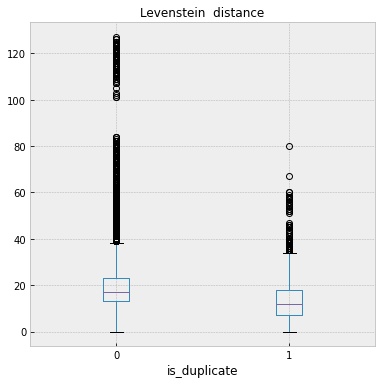

In [34]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

/home/ivan/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


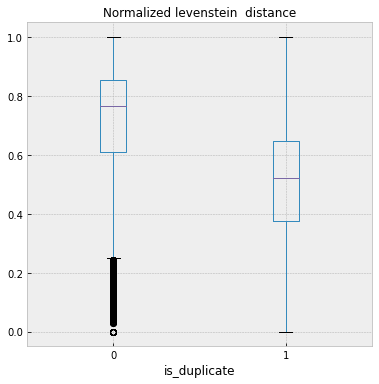

In [35]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Базовая модель

In [36]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [37]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [38]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(class_weight='balanced')

In [39]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [40]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [41]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    395329
           1       0.17      0.13      0.15      2926

    accuracy                           0.99    398255
   macro avg       0.58      0.56      0.57    398255
weighted avg       0.99      0.99      0.99    398255



In [42]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98832
           1       0.17      0.14      0.15       732

    accuracy                           0.99     99564
   macro avg       0.58      0.57      0.57     99564
weighted avg       0.99      0.99      0.99     99564



In [43]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.14792338327327895
0.15128593040847202


# Генерация сабмита

In [44]:
sample_sub = pd.read_csv(DATA_DIR.joinpath("sample_submission.csv"), index_col="pair_id")

In [45]:
sample_sub

,is_duplicate
pair_id,
1,1
2,1
3,1
4,1
5,1
...,...
213245,1
213246,1
213247,1


In [46]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [47]:
sample_sub.is_duplicate.value_counts()

0    211968
1      1281
Name: is_duplicate, dtype: int64

In [48]:
sample_sub.to_csv(DATA_DIR.joinpath("baseline_submission.csv"))